🚀 Iniciando Sistema de Análisis Biomecánico...
📋 Verificando requisitos del sistema...
  SISTEMA DE ANÁLISIS BIOMECÁNICO PARA SALTO LARGO

Iniciando interfaz gráfica...
------------------------------------------------------------


2025-08-13 00:24:26,485 - INFO - Cámara inicializada: 1280x720 @ 30.0 FPS
2025-08-13 00:24:28,669 - INFO - Grabación de video iniciada: salto_largo_20250813_002428.mp4
2025-08-13 00:24:28,669 - INFO - Grabación visual iniciada
2025-08-13 00:24:28,669 - INFO - Simulación IMU iniciada
2025-08-13 00:24:56,555 - INFO - Video guardado: salto_largo_20250813_002428.mp4
2025-08-13 00:24:56,555 - INFO - Grabación visual detenida



✅ Sistema finalizado correctamente.
👋 ¡Hasta luego!


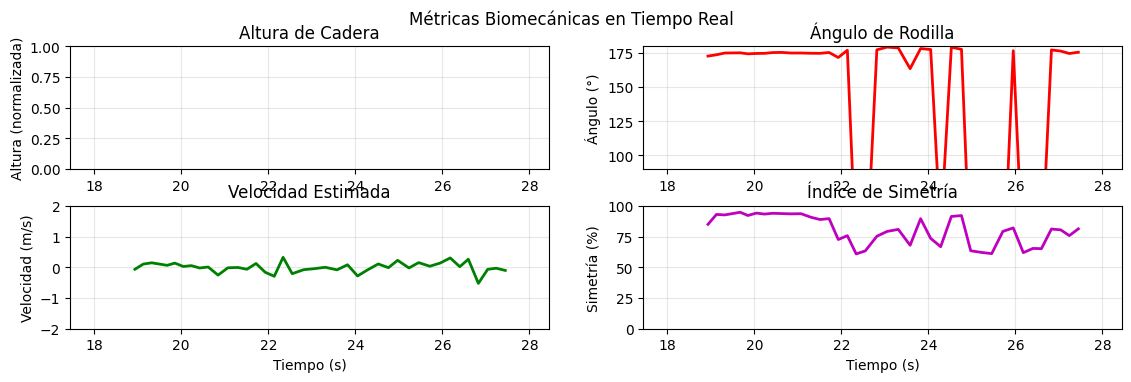

In [ ]:
"""
SISTEMA DE ANÁLISIS BIOMECÁNICO PARA SALTO LARGO
================================================================

Este sistema implementa una solución híbrida inercial-visual para el análisis 
técnico y físico del salto largo en deportistas. Combina:

1. ANÁLISIS VISUAL: Utiliza MediaPipe para detectar 33 puntos clave del cuerpo humano
2. SIMULACIÓN IMU: Simula 11 sensores inerciales distribuidos estratégicamente
3. ANÁLISIS BIOMECÁNICO: Calcula métricas específicas del salto largo en tiempo real
4. INTERFAZ GRÁFICA: Proporciona visualización y control del sistema

CARACTERÍSTICAS PRINCIPALES:
- Análisis en tiempo real de técnica de salto
- Cálculo de centro de masa corporal
- Medición de ángulos articulares críticos
- Evaluación de simetría bilateral
- Exportación de datos para análisis posterior

REQUISITOS TÉCNICOS:
- Python 3.8+
- OpenCV para captura de video
- MediaPipe para análisis postural
- Tkinter para interfaz gráfica
- Matplotlib para gráficos en tiempo real

Autor: Daniel Andres Ramirez Segura
Versión: 1.1
Fecha Creación: 01 Agosto 2025
Actualización: 12 Agosto 2025
"""

import cv2
import numpy as np
import pandas as pd
import mediapipe as mp
import threading
import queue
import time
from datetime import datetime
import json
import math
from collections import deque
import logging
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.animation import FuncAnimation
import os
from PIL import Image, ImageTk
import warnings
warnings.filterwarnings("ignore")

# Configuración del sistema de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


# =============================================================================
# CLASE PRINCIPAL: ADQUISICIÓN DE DATOS VISUALES
# =============================================================================

class AdquisicionDataCamara:
    """
    CLASE PARA ADQUISICIÓN Y PROCESAMIENTO DE DATOS VISUALES
    
    Esta clase es el núcleo del análisis visual del sistema. Se encarga de:
    - Capturar video desde la cámara del computador
    - Procesar cada frame con MediaPipe para detectar poses humanas
    - Calcular métricas biomecánicas específicas del salto largo
    - Almacenar datos en buffers circulares para análisis en tiempo real
    
    FUNCIONAMIENTO:
    1. Inicializa la cámara con resolución y FPS específicos
    2. Cada frame capturado se procesa con MediaPipe
    3. Se extraen 33 puntos clave del cuerpo humano
    4. Se calculan métricas biomecánicas derivadas
    5. Los datos se almacenan para análisis posterior
    """

    def __init__(self, camera_id=0, fps=30, resolution=(1280, 720)):
        self.camera_id = camera_id
        self.fps = fps
        self.resolution = resolution
        self.is_recording = False
        self.show_preview = True
        self.video_writer = None
        self.video_filename = None
        self.current_frame = None
        self.mp_pose = mp.solutions.pose
        self.mp_drawing = mp.solutions.drawing_utils
        self.pose = self.mp_pose.Pose(
            static_image_mode=False,
            model_complexity=2,
            enable_segmentation=False,
            min_detection_confidence=0.7,
            min_tracking_confidence=0.8
        )
        self.visual_data_buffer = deque(maxlen=5000)  # Reducido para mejor rendimiento
        self.frame_buffer = deque(maxlen=30)  # Reducido para optimizar memoria
        self.iniciar_camara()

    def iniciar_camara(self):
        try:
            self.cap = cv2.VideoCapture(self.camera_id)
            if not self.cap.isOpened():
                raise Exception(f"No se puede abrir la cámara {self.camera_id}")
            self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, self.resolution[0])
            self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, self.resolution[1])
            self.cap.set(cv2.CAP_PROP_FPS, self.fps)
            self.cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
            actual_fps = self.cap.get(cv2.CAP_PROP_FPS)
            actual_width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            actual_height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            logger.info(f"Cámara inicializada: {actual_width}x{actual_height} @ {actual_fps} FPS")
        except Exception as e:
            logger.error(f"Error inicializando cámara: {e}")
            raise

    def procesar_frame_mediapipe(self, frame):
        try:
            self.current_frame = frame.copy()
            if self.video_writer and self.video_writer.isOpened():
                # Dibujar landmarks en el frame para grabación
                rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = self.pose.process(rgb_frame)
                if results.pose_landmarks:
                    self.mp_drawing.draw_landmarks(
                        self.current_frame,
                        results.pose_landmarks,
                        self.mp_pose.POSE_CONNECTIONS,
                        landmark_drawing_spec=self.mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                        connection_drawing_spec=self.mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
                    )
                self.video_writer.write(self.current_frame)
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = self.pose.process(rgb_frame)
            landmarks_data = {}
            if results.pose_landmarks:
                landmarks = results.pose_landmarks.landmark
                for idx, landmark in enumerate(landmarks):
                    landmarks_data[f'landmark_{idx}_x'] = landmark.x
                    landmarks_data[f'landmark_{idx}_y'] = landmark.y
                    landmarks_data[f'landmark_{idx}_z'] = landmark.z
                    landmarks_data[f'landmark_{idx}_visibility'] = landmark.visibility
                bio_metrics = self.calcular_metricas_biomecanicas(landmarks)
                landmarks_data.update(bio_metrics)
                quality_metrics = self.calcular_metricas_de_calidad(landmarks)
                landmarks_data.update(quality_metrics)
                if self.show_preview:
                    self.mp_drawing.draw_landmarks(
                        self.current_frame,
                        results.pose_landmarks,
                        self.mp_pose.POSE_CONNECTIONS,
                        landmark_drawing_spec=self.mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                        connection_drawing_spec=self.mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
                    )
                    self.frame_buffer.append(self.current_frame.copy())
            else:
                landmarks_data = self._get_empty_landmarks()
            return landmarks_data
        except Exception as e:
            logger.error(f"Error procesando frame: {e}")
            return self._get_empty_landmarks()

    def _get_empty_landmarks(self):
        landmarks_data = {}
        for idx in range(33):
            landmarks_data[f'landmark_{idx}_x'] = np.nan
            landmarks_data[f'landmark_{idx}_y'] = np.nan
            landmarks_data[f'landmark_{idx}_z'] = np.nan
            landmarks_data[f'landmark_{idx}_visibility'] = 0.0
        landmarks_data.update({
            'detection_confidence': 0.0,
            'detection_completeness': 0.0,
            'valid_landmarks': 0,
            'center_of_mass_x': np.nan,
            'center_of_mass_y': np.nan,
            'knee_angle_right': np.nan,
            'knee_angle_left': np.nan,
            'trunk_angle': np.nan,
            'hip_height': np.nan,
            'symmetry_index': 0.0,
            'velocity_x_estimated': 0.0
        })
        return landmarks_data

    def calcular_metricas_biomecanicas(self, landmarks):
        metrics = {}
        try:
            com_x, com_y = self.calcular_centro_de_masa(landmarks)
            metrics['center_of_mass_x'] = com_x
            metrics['center_of_mass_y'] = com_y
            knee_angle_r = self.calcular_angulo_articular(landmarks[24], landmarks[26], landmarks[28])
            metrics['knee_angle_right'] = knee_angle_r
            knee_angle_l = self.calcular_angulo_articular(landmarks[23], landmarks[25], landmarks[27])
            metrics['knee_angle_left'] = knee_angle_l
            trunk_angle = self.calcular_angulo_tronco(landmarks)
            metrics['trunk_angle'] = trunk_angle
            hip_height = (landmarks[23].y + landmarks[24].y) / 2
            metrics['hip_height'] = 1.0 - hip_height
            symmetry_index = self.calcular_simetria_bilateral(landmarks)
            metrics['symmetry_index'] = symmetry_index
            if len(self.visual_data_buffer) > 0:
                prev_com_x = self.visual_data_buffer[-1].get('center_of_mass_x', com_x)
                time_delta = 1.0 / self.fps
                velocity_x = (com_x - prev_com_x) / time_delta if time_delta > 0 else 0
                metrics['velocity_x_estimated'] = velocity_x
            else:
                metrics['velocity_x_estimated'] = 0.0
        except Exception as e:
            logger.warning(f"Error calculando métricas biomecánicas: {e}")
        return metrics

    def calcular_centro_de_masa(self, landmarks):
        segment_weights = {
            'head': 0.08, 'trunk': 0.50, 'arms': 0.10, 'thighs': 0.20, 'shanks': 0.12
        }
        head_x, head_y = landmarks[0].x, landmarks[0].y
        trunk_x = (landmarks[11].x + landmarks[12].x + landmarks[23].x + landmarks[24].x) / 4
        trunk_y = (landmarks[11].y + landmarks[12].y + landmarks[23].y + landmarks[24].y) / 4
        arms_x = (landmarks[13].x + landmarks[14].x + landmarks[15].x + landmarks[16].x) / 4
        arms_y = (landmarks[13].y + landmarks[14].y + landmarks[15].y + landmarks[16].y) / 4
        thighs_x = (landmarks[25].x + landmarks[26].x) / 2
        thighs_y = (landmarks[25].y + landmarks[26].y) / 2
        shanks_x = (landmarks[27].x + landmarks[28].x) / 2
        shanks_y = (landmarks[27].y + landmarks[28].y) / 2
        com_x = sum(segment_weights[k] * v for k, v in zip(segment_weights, [head_x, trunk_x, arms_x, thighs_x, shanks_x]))
        com_y = sum(segment_weights[k] * v for k, v in zip(segment_weights, [head_y, trunk_y, arms_y, thighs_y, shanks_y]))
        return com_x, com_y

    def calcular_angulo_articular(self, point1, point2, point3):
        try:
            a = np.array([point1.x, point1.y])
            b = np.array([point2.x, point2.y])
            c = np.array([point3.x, point3.y])
            ba = a - b
            bc = c - b
            cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
            cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
            angle = np.arccos(cosine_angle)
            return np.degrees(angle)
        except:
            return np.nan

    def calcular_angulo_tronco(self, landmarks):
        try:
            shoulder_mid_x = (landmarks[11].x + landmarks[12].x) / 2
            shoulder_mid_y = (landmarks[11].y + landmarks[12].y) / 2
            hip_mid_x = (landmarks[23].x + landmarks[24].x) / 2
            hip_mid_y = (landmarks[23].y + landmarks[24].y) / 2
            trunk_vector = np.array([hip_mid_x - shoulder_mid_x, hip_mid_y - shoulder_mid_y])
            vertical_vector = np.array([0, 1])
            cosine_angle = np.dot(trunk_vector, vertical_vector) / (
                np.linalg.norm(trunk_vector) * np.linalg.norm(vertical_vector)
            )
            cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
            angle = np.arccos(cosine_angle)
            return np.degrees(angle)
        except:
            return np.nan

    def calcular_simetria_bilateral(self, landmarks):
        try:
            left_knee_y = landmarks[25].y
            right_knee_y = landmarks[26].y
            left_ankle_y = landmarks[27].y
            right_ankle_y = landmarks[28].y
            knee_diff = abs(left_knee_y - right_knee_y)
            ankle_diff = abs(left_ankle_y - right_ankle_y)
            symmetry = 100 * (1 - (knee_diff + ankle_diff) / 2)
            return max(0, symmetry)
        except:
            return 0.0

    def calcular_metricas_de_calidad(self, landmarks):
        try:
            key_landmarks = [11, 12, 13, 14, 23, 24, 25, 26, 27, 28]
            confidences = [landmarks[i].visibility for i in key_landmarks]
            avg_confidence = np.mean(confidences)
            valid_landmarks = sum(1 for conf in confidences if conf > 0.5)
            completeness = valid_landmarks / len(key_landmarks)
            return {
                'detection_confidence': avg_confidence,
                'detection_completeness': completeness,
                'valid_landmarks': valid_landmarks
            }
        except:
            return {
                'detection_confidence': 0.0,
                'detection_completeness': 0.0,
                'valid_landmarks': 0
            }

    def capturar_datos_visuales(self):
        frame_count = 0
        start_time = time.time()
        while self.is_recording:
            ret, frame = self.cap.read()
            if ret:
                timestamp = time.time()
                landmarks_data = self.procesar_frame_mediapipe(frame)
                visual_sample = {
                    'timestamp': timestamp,
                    'frame_number': frame_count,
                    'elapsed_time': timestamp - start_time,
                    **landmarks_data
                }
                self.visual_data_buffer.append(visual_sample)
                frame_count += 1
                expected_time = start_time + (frame_count / self.fps)
                current_time = time.time()
                sleep_time = expected_time - current_time
                if sleep_time > 0:
                    time.sleep(sleep_time)
            else:
                logger.warning("No se pudo capturar frame de la cámara")
                time.sleep(0.1)

    def obtener_ultimo_frame(self):
        if self.frame_buffer:
            return self.frame_buffer[-1]
        return None

    def comenzar_grabacion(self):
        self.is_recording = True
        self.hilo_visual = threading.Thread(target=self.capturar_datos_visuales, daemon=True)
        self.hilo_visual.start()
        logger.info("Grabación visual iniciada")

    def detener_grabacion(self):
        self.is_recording = False
        if hasattr(self, 'hilo_visual'):
            self.hilo_visual.join(timeout=2)
        if self.video_writer:
            self.video_writer.release()
            self.video_writer = None
            logger.info(f"Video guardado: {self.video_filename}")
        logger.info("Grabación visual detenida")

    def obtener_datos_visuales(self):
        return list(self.visual_data_buffer)

    def obtener_frame_actual(self):
        return self.current_frame

    def iniciar_grabacion_video(self, filename=None):
        if filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"salto_largo_{timestamp}.mp4"
        self.video_filename = filename
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        self.video_writer = cv2.VideoWriter(
            filename,
            fourcc,
            self.fps,
            self.resolution
        )
        if not self.video_writer.isOpened():
            logger.error(f"No se pudo crear el archivo de video: {filename}")
            self.video_writer = None
            return False
        logger.info(f"Grabación de video iniciada: {filename}")
        return True

    def __del__(self):
        if hasattr(self, 'video_writer') and self.video_writer:
            self.video_writer.release()
        if hasattr(self, 'cap'):
            self.cap.release()

# =============================================================================
# CLASE 2: INTERFAZ BIOMECÁNICA
# =============================================================================

class Interfaz_Biomecanica:
    def __init__(self):
        self.root = tk.Tk()
        self.root.title("Sistema de Análisis Biomecánico - Salto Largo")
        self.root.geometry("1200x800")
        self.camera_system = None
        self.imu_simulator = None
        self.is_recording = False
        self.athlete_id = tk.StringVar(value="atleta_001")
        self.session_type = tk.StringVar(value="entrenamiento")
        self.recording_duration = tk.IntVar(value=30)
        self.video_window = None
        self.video_label = None
        self.is_showing_video = False
        self.save_video = tk.BooleanVar(value=True)
        self.plot_data = {
            'time': deque(maxlen=100),
            'hip_height': deque(maxlen=100),
            'knee_angle': deque(maxlen=100),
            'velocity': deque(maxlen=100),
            'symmetry': deque(maxlen=100)
        }
        self.setup_ui()
        self.setup_plots()
        self.update_timer = None

    def setup_ui(self):
        control_frame = ttk.LabelFrame(self.root, text="Control de Adquisición", padding="10")
        control_frame.pack(fill="x", padx=10, pady=5)
        config_frame = ttk.Frame(control_frame)
        config_frame.pack(fill="x")
        ttk.Label(config_frame, text="ID Atleta:").grid(row=0, column=0, sticky="w", padx=5)
        ttk.Entry(config_frame, textvariable=self.athlete_id, width=15).grid(row=0, column=1, padx=5)
        ttk.Label(config_frame, text="Tipo de Sesión:").grid(row=0, column=2, sticky="w", padx=5)
        session_combo = ttk.Combobox(config_frame, textvariable=self.session_type, width=15)
        session_combo['values'] = ('entrenamiento', 'competencia', 'evaluacion', 'rehabilitacion')
        session_combo.grid(row=0, column=3, padx=5)
        ttk.Label(config_frame, text="Duración (s):").grid(row=0, column=4, sticky="w", padx=5)
        ttk.Entry(config_frame, textvariable=self.recording_duration, width=10).grid(row=0, column=5, padx=5)
        button_frame = ttk.Frame(control_frame)
        button_frame.pack(fill="x", pady=10)
        self.init_button = ttk.Button(button_frame, text="Inicializar Sistema", command=self.initialize_system)
        self.init_button.pack(side="left", padx=5)
        self.start_button = ttk.Button(button_frame, text="Iniciar Grabación", command=self.comenzar_grabacion, state="disabled")
        self.start_button.pack(side="left", padx=5)
        self.stop_button = ttk.Button(button_frame, text="Detener Grabación", command=self.detener_grabacion, state="disabled")
        self.stop_button.pack(side="left", padx=5)
        self.export_button = ttk.Button(button_frame, text="Exportar Datos", command=self.export_data, state="disabled")
        self.export_button.pack(side="left", padx=5)
        self.save_video_check = ttk.Checkbutton(button_frame, text="Guardar Video", variable=self.save_video)
        self.save_video_check.pack(side="left", padx=5)
        self.video_button = ttk.Button(button_frame, text="Mostrar Cámara", command=self.toggle_video_window, state="disabled")
        self.video_button.pack(side="left", padx=5)
        status_frame = ttk.LabelFrame(self.root, text="Estado del Sistema", padding="10")
        status_frame.pack(fill="x", padx=10, pady=5)
        self.status_text = tk.Text(status_frame, height=4, wrap="word")
        self.status_text.pack(fill="x")
        metrics_frame = ttk.LabelFrame(self.root, text="Métricas en Tiempo Real", padding="10")
        metrics_frame.pack(fill="both", expand=True, padx=10, pady=5)
        self.current_metrics = {
            'hip_height': tk.StringVar(value="--"),
            'knee_angle_r': tk.StringVar(value="--"),
            'trunk_angle': tk.StringVar(value="--"),
            'velocity': tk.StringVar(value="--"),
            'symmetry': tk.StringVar(value="--"),
            'confidence': tk.StringVar(value="--")
        }
        metrics_display = ttk.Frame(metrics_frame)
        metrics_display.pack(fill="x")
        ttk.Label(metrics_display, text="Altura Cadera:").grid(row=0, column=0, sticky="w")
        ttk.Label(metrics_display, textvariable=self.current_metrics['hip_height']).grid(row=0, column=1)
        ttk.Label(metrics_display, text="Ángulo Rodilla:").grid(row=0, column=2, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['knee_angle_r']).grid(row=0, column=3)
        ttk.Label(metrics_display, text="Ángulo Tronco:").grid(row=0, column=4, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['trunk_angle']).grid(row=0, column=5)
        ttk.Label(metrics_display, text="Velocidad Est.:").grid(row=1, column=0, sticky="w")
        ttk.Label(metrics_display, textvariable=self.current_metrics['velocity']).grid(row=1, column=1)
        ttk.Label(metrics_display, text="Simetría:").grid(row=1, column=2, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['symmetry']).grid(row=1, column=3)
        ttk.Label(metrics_display, text="Confianza:").grid(row=1, column=4, sticky="w", padx=(20,0))
        ttk.Label(metrics_display, textvariable=self.current_metrics['confidence']).grid(row=1, column=5)
        self.plot_frame = ttk.Frame(metrics_frame)
        self.plot_frame.pack(fill="both", expand=True, pady=10)

    def toggle_video_window(self):
        if not self.is_showing_video:
            self.show_video_window()
        else:
            self.hide_video_window()

    def show_video_window(self):
        if self.video_window is None:
            self.video_window = tk.Toplevel(self.root)
            self.video_window.title("Vista de Cámara - Análisis Biomecánico")
            self.video_window.geometry("800x600")
            self.video_window.protocol("WM_DELETE_WINDOW", self.hide_video_window)
            video_frame = ttk.Frame(self.video_window)
            video_frame.pack(fill="both", expand=True, padx=10, pady=10)
            self.video_label = tk.Label(video_frame)
            self.video_label.pack(fill="both", expand=True)
            info_frame = ttk.Frame(self.video_window)
            info_frame.pack(fill="x", padx=10, pady=5)
            self.video_info_label = ttk.Label(info_frame, text="Esperando frames...", font=("Arial", 10))
            self.video_info_label.pack(side="left")
            self.recording_status_label = ttk.Label(info_frame, text="", font=("Arial", 10, "bold"), foreground="red")
            self.recording_status_label.pack(side="right")
            self.is_showing_video = True
            self.video_button.config(text="Ocultar Cámara")
            self.log_message("Ventana de video abierta")
            self.update_video_display()

    def hide_video_window(self):
        if self.video_window:
            self.video_window.destroy()
            self.video_window = None
            self.video_label = None
            self.is_showing_video = False
            self.video_button.config(text="Mostrar Cámara")
            self.log_message("Ventana de video cerrada")

    def update_video_display(self):
        if not self.is_showing_video or not self.video_window:
            return
        if self.camera_system:
            frame = self.camera_system.obtener_frame_actual()
            if frame is not None:
                height, width = frame.shape[:2]
                max_width = 780
                max_height = 550
                scale = min(max_width/width, max_height/height)
                new_width = int(width * scale)
                new_height = int(height * scale)
                frame_resized = cv2.resize(frame, (new_width, new_height))
                frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
                image = Image.fromarray(frame_rgb)
                photo = ImageTk.PhotoImage(image=image)
                self.video_label.config(image=photo)
                self.video_label.image = photo
                if self.is_recording:
                    self.recording_status_label.config(text="● GRABANDO", foreground="red")
                    visual_data = self.camera_system.obtener_datos_visuales()
                    if visual_data:
                        fps_actual = len(visual_data) / visual_data[-1]['elapsed_time'] if visual_data[-1]['elapsed_time'] > 0 else 0
                        self.video_info_label.config(
                            text=f"FPS: {fps_actual:.1f} | Frames: {len(visual_data)} | Tiempo: {visual_data[-1]['elapsed_time']:.1f}s"
                        )
                else:
                    self.recording_status_label.config(text="", foreground="black")
                    self.video_info_label.config(text="Vista previa activa")
        if self.is_showing_video:
            self.video_window.after(33, self.update_video_display)

    def setup_plots(self):
        self.fig, self.axes = plt.subplots(2, 2, figsize=(10, 6))
        self.fig.suptitle("Métricas Biomecánicas en Tiempo Real")
        self.axes[0, 0].set_title("Altura de Cadera")
        self.axes[0, 0].set_ylabel("Altura (normalizada)")
        self.line_hip, = self.axes[0, 0].plot([], [], 'b-', linewidth=2)
        self.axes[0, 1].set_title("Ángulo de Rodilla")
        self.axes[0, 1].set_ylabel("Ángulo (°)")
        self.line_knee, = self.axes[0, 1].plot([], [], 'r-', linewidth=2)
        self.axes[1, 0].set_title("Velocidad Estimada")
        self.axes[1, 0].set_ylabel("Velocidad (m/s)")
        self.axes[1, 0].set_xlabel("Tiempo (s)")
        self.line_velocity, = self.axes[1, 0].plot([], [], 'g-', linewidth=2)
        self.axes[1, 1].set_title("Índice de Simetría")
        self.axes[1, 1].set_ylabel("Simetría (%)")
        self.axes[1, 1].set_xlabel("Tiempo (s)")
        self.line_symmetry, = self.axes[1, 1].plot([], [], 'm-', linewidth=2)
        for ax in self.axes.flat:
            ax.set_xlim(0, 10)
            ax.grid(True, alpha=0.3)
        self.axes[0, 0].set_ylim(0, 1)
        self.axes[0, 1].set_ylim(90, 180)
        self.axes[1, 0].set_ylim(-2, 2)
        self.axes[1, 1].set_ylim(0, 100)
        plt.tight_layout()
        self.canvas = FigureCanvasTkAgg(self.fig, self.plot_frame)
        self.canvas.get_tk_widget().pack(fill="both", expand=True)

    def log_message(self, message):
        timestamp = datetime.now().strftime("%H:%M:%S")
        self.status_text.insert("end", f"[{timestamp}] {message}\n")
        self.status_text.see("end")
        self.root.update_idletasks()

    def initialize_system(self):
        try:
            self.log_message("Validando disponibilidad de cámara...")
            camera_found = False
            camera_id = 0
            for test_id in [0, 1, 2]:
                try:
                    test_cap = cv2.VideoCapture(test_id)
                    if test_cap.isOpened():
                        ret, frame = test_cap.read()
                        test_cap.release()
                        if ret and frame is not None:
                            camera_id = test_id
                            camera_found = True
                            self.log_message(f"✅ Cámara encontrada en ID: {camera_id}")
                            break
                    else:
                        test_cap.release()
                except:
                    continue
            if not camera_found:
                raise Exception("No se encontró ninguna cámara funcional.")
            self.log_message("Inicializando sistema de cámara...")
            self.camera_system = AdquisicionDataCamara(camera_id=camera_id, fps=30)
            self.log_message("✅ Cámara inicializada correctamente")
            self.log_message("Inicializando simulador IMU...")
            self.imu_simulator = Simulador_IMU(num_sensors=11, sample_rate=1000)
            self.log_message("✅ Simulador IMU inicializado")
            self.start_button.config(state="normal")
            self.init_button.config(state="disabled")
            self.video_button.config(state="normal")
            self.log_message("🎉 Sistema listo para grabación")
            self.start_interface_updates()
        except Exception as e:
            error_msg = f"❌ Error inicializando sistema: {str(e)}"
            self.log_message(error_msg)
            messagebox.showerror("Error de Inicialización", error_msg)

    def start_interface_updates(self):
        self.update_interface()
        self.update_timer = self.root.after(50, self.start_interface_updates)

    def stop_interface_updates(self):
        if self.update_timer:
            self.root.after_cancel(self.update_timer)
            self.update_timer = None

    def comenzar_grabacion(self):
        try:
            if not self.camera_system:
                raise Exception("Sistema de cámara no inicializado")
            self.is_recording = True
            if self.save_video.get():
                self.camera_system.iniciar_grabacion_video()
            self.camera_system.comenzar_grabacion()
            if self.imu_simulator:
                self.imu_simulator.comenzar_grabacion(self.camera_system)
            self.start_button.config(state="disabled")
            self.stop_button.config(state="normal")
            self.export_button.config(state="normal")
            self.log_message("🎥 Grabación iniciada")
            self.start_interface_updates()
        except Exception as e:
            self.log_message(f"❌ Error iniciando grabación: {e}")
            messagebox.showerror("Error", f"No se pudo iniciar la grabación: {e}")

    def detener_grabacion(self):
        try:
            self.is_recording = False
            if self.camera_system:
                self.camera_system.detener_grabacion()
            if self.imu_simulator:
                self.imu_simulator.detener_grabacion()
            self.start_button.config(state="normal")
            self.stop_button.config(state="disabled")
            self.stop_interface_updates()
            self.show_recording_stats()
            self.log_message("⏹ Grabación detenida")
        except Exception as e:
            self.log_message(f"❌ Error deteniendo grabación: {e}")
            messagebox.showerror("Error", f"No se pudo detener la grabación: {e}")

    def update_interface(self):
        if not self.is_recording or not self.camera_system:
            return
        visual_data = self.camera_system.obtener_datos_visuales()
        if visual_data:
            latest = visual_data[-1]
            self.current_metrics['hip_height'].set(f"{latest.get('hip_height', 0):.3f}")
            self.current_metrics['knee_angle_r'].set(f"{latest.get('knee_angle_right', 0):.1f}°")
            self.current_metrics['trunk_angle'].set(f"{latest.get('trunk_angle', 0):.1f}°")
            self.current_metrics['velocity'].set(f"{latest.get('velocity_x_estimated', 0):.2f} m/s")
            self.current_metrics['symmetry'].set(f"{latest.get('symmetry_index', 0):.1f}%")
            self.current_metrics['confidence'].set(f"{latest.get('detection_confidence', 0):.2f}")
            current_time = latest.get('elapsed_time', 0)
            self.plot_data['time'].append(current_time)
            self.plot_data['hip_height'].append(latest.get('hip_height', 0))
            self.plot_data['knee_angle'].append(latest.get('knee_angle_right', 180))
            self.plot_data['velocity'].append(latest.get('velocity_x_estimated', 0))
            self.plot_data['symmetry'].append(latest.get('symmetry_index', 0))
            self.update_plots()
            if len(visual_data) % 30 == 0:
                confidence = latest.get('detection_confidence', 0)
                if confidence < 0.5:
                    self.log_message(f"⚠️ Confianza de detección baja: {confidence:.2f}")
        else:
            for metric_name in self.current_metrics:
                self.current_metrics[metric_name].set("--")

    def update_plots(self):
        if len(self.plot_data['time']) < 2:
            return
        time_data = list(self.plot_data['time'])
        self.line_hip.set_data(time_data, list(self.plot_data['hip_height']))
        self.line_knee.set_data(time_data, list(self.plot_data['knee_angle']))
        self.line_velocity.set_data(time_data, list(self.plot_data['velocity']))
        self.line_symmetry.set_data(time_data, list(self.plot_data['symmetry']))
        if time_data:
            max_time = max(time_data)
            for ax in self.axes.flat:
                ax.set_xlim(max(0, max_time - 10), max_time + 1)
        self.canvas.draw_idle()

    def show_recording_stats(self):
        if not self.camera_system:
            return
        visual_data = self.camera_system.obtener_datos_visuales()
        imu_data = self.imu_simulator.obtener_datos_imu() if self.imu_simulator else []
        if visual_data:
            duration = visual_data[-1]['elapsed_time']
            avg_fps = len(visual_data) / duration if duration > 0 else 0
            stats_msg = f"""
Estadísticas de la Grabación:
- Muestras visuales: {len(visual_data)}
- Muestras IMU simuladas: {len(imu_data)}
- Duración total: {duration:.1f}s
- FPS promedio: {avg_fps:.1f}
"""
        else:
            stats_msg = "No se capturaron datos en esta sesión"
        self.log_message(stats_msg)

    def export_data(self):
        try:
            if not self.camera_system:
                messagebox.showerror("Error", "No hay datos para exportar")
                return
            visual_data = self.camera_system.obtener_datos_visuales()
            imu_data = self.imu_simulator.obtener_datos_imu() if self.imu_simulator else []
            if not visual_data:
                messagebox.showerror("Error", "No hay datos visuales para exportar")
                return
            export_dir = filedialog.askdirectory(title="Seleccionar directorio de exportación")
            if not export_dir:
                return
            session_id = datetime.now().strftime("%Y%m%d_%H%M%S")
            athlete_id = self.athlete_id.get()
            session_type = self.session_type.get()
            visual_df = pd.DataFrame(visual_data)
            visual_file = f"{export_dir}/{athlete_id}_{session_type}_visual_{session_id}.csv"
            visual_df.to_csv(visual_file, index=False, sep=';', decimal=',')
            if imu_data:
                imu_df = pd.DataFrame(imu_data)
                imu_file = f"{export_dir}/{athlete_id}_{session_type}_imu_sim_{session_id}.csv"
                imu_df.to_csv(imu_file, index=False, sep=';', decimal=',')
            metadata = {
                'session_id': session_id,
                'athlete_id': athlete_id,
                'session_type': session_type,
                'timestamp': datetime.now().isoformat(),
                'visual_samples': len(visual_data),
                'imu_samples': len(imu_data),
                'duration_seconds': visual_data[-1]['elapsed_time'] if visual_data else 0,
                'camera_fps': self.camera_system.fps,
                'imu_sample_rate': self.imu_simulator.sample_rate if self.imu_simulator else 0,
                'system_version': '1.0',
                'notes': 'Datos capturados con simulación IMU para desarrollo y demostración'
            }
            metadata_file = f"{export_dir}/{athlete_id}_{session_type}_metadata_{session_id}.json"
            with open(metadata_file, 'w', encoding='utf-8') as f:
                json.dump(metadata, f, indent=2, ensure_ascii=False)
            report_file = f"{export_dir}/{athlete_id}_{session_type}_reporte_{session_id}.txt"
            self.generate_simple_report(visual_data, report_file)
            success_msg = f"""
Datos exportados exitosamente:
- Archivo visual: {visual_file}
- Archivo IMU: {imu_file if imu_data else 'No generado'}
- Metadatos: {metadata_file}
- Reporte: {report_file}
"""
            self.log_message(success_msg)
            messagebox.showinfo("Exportación Exitosa", f"Datos exportados a:\n{export_dir}")
        except Exception as e:
            error_msg = f"Error exportando datos: {str(e)}"
            self.log_message(error_msg)
            messagebox.showerror("Error", error_msg)

    def generate_simple_report(self, visual_data, report_file):
        try:
            df = pd.DataFrame(visual_data)
            with open(report_file, 'w', encoding='utf-8') as f:
                f.write("REPORTE DE ANÁLISIS BIOMECÁNICO - SALTO LARGO\n")
                f.write("=" * 50 + "\n\n")
                f.write(f"Atleta: {self.athlete_id.get()}\n")
                f.write(f"Sesión: {self.session_type.get()}\n")
                f.write(f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                f.write(f"Duración: {df['elapsed_time'].max():.1f} segundos\n")
                f.write(f"Muestras: {len(df)}\n\n")
                f.write("ESTADÍSTICAS PRINCIPALES:\n")
                f.write("-" * 30 + "\n")
                hip_height = df['hip_height'].dropna()
                if not hip_height.empty:
                    f.write(f"Altura de cadera:\n")
                    f.write(f"  - Promedio: {hip_height.mean():.3f}\n")
                    f.write(f"  - Máximo: {hip_height.max():.3f}\n")
                    f.write(f"  - Mínimo: {hip_height.min():.3f}\n")
                    f.write(f"  - Desv. Est.: {hip_height.std():.3f}\n\n")
                knee_angle = df['knee_angle_right'].dropna()
                if not knee_angle.empty:
                    f.write(f"Ángulo de rodilla derecha:\n")
                    f.write(f"  - Promedio: {knee_angle.mean():.1f}°\n")
                    f.write(f"  - Máximo: {knee_angle.max():.1f}°\n")
                    f.write(f"  - Mínimo: {knee_angle.min():.1f}°\n")
                    f.write(f"  - Desv. Est.: {knee_angle.std():.1f}°\n\n")
                symmetry = df['symmetry_index'].dropna()
                if not symmetry.empty:
                    f.write(f"Índice de simetría:\n")
                    f.write(f"  - Promedio: {symmetry.mean():.1f}%\n")
                    f.write(f"  - Máximo: {symmetry.max():.1f}%\n")
                    f.write(f"  - Mínimo: {symmetry.min():.1f}%\n\n")
                confidence = df['detection_confidence'].dropna()
                if not confidence.empty:
                    high_confidence_count = (confidence > 0.7).sum()
                    f.write(f"Calidad de detección:\n")
                    f.write(f"  - Confianza promedio: {confidence.mean():.2f}\n")
                    f.write(f"  - Muestras con alta confianza (>0.7): {high_confidence_count}/{len(confidence)} ({100*high_confidence_count/len(confidence):.1f}%)\n")
                    if confidence.mean() > 0.8:
                        f.write("  - Evaluación: EXCELENTE calidad de detección\n")
                    elif confidence.mean() > 0.6:
                        f.write("  - Evaluación: BUENA calidad de detección\n")
                    elif confidence.mean() > 0.4:
                        f.write("  - Evaluación: REGULAR calidad de detección\n")
                    else:
                        f.write("  - Evaluación: POBRE calidad de detección\n")
        except Exception as e:
            logger.warning(f"Error generando reporte: {e}")

    def run(self):
        self.log_message("=== SISTEMA DE ANÁLISIS BIOMECÁNICO PARA SALTO LARGO ===")
        self.log_message("Sistema iniciado correctamente")
        self.log_message("INSTRUCCIONES:")
        self.log_message("1. Configure ID de atleta y tipo de sesión")
        self.log_message("2. Presione 'Inicializar Sistema' para preparar cámara")
        self.log_message("3. Presione 'Iniciar Grabación' para comenzar análisis")
        self.log_message("4. Use 'Exportar Datos' para guardar resultados")
        self.root.mainloop()

def main():
    try:
        print("=" * 60)
        print("  SISTEMA DE ANÁLISIS BIOMECÁNICO PARA SALTO LARGO")
        print("=" * 60)
        print("")
        print("Iniciando interfaz gráfica...")
        print("-" * 60)
        app = Interfaz_Biomecanica()
        app.run()
        print("\n✅ Sistema finalizado correctamente.")
    except Exception as e:
        logger.error(f"Error crítico en la aplicación principal: {e}")
        print(f"\n❌ ERROR CRÍTICO: {e}")
        print("\n🔧 POSIBLES SOLUCIONES:")
        print("1. Verificar que la cámara esté conectada y disponible")
        print("2. Reinstalar librerías: pip install --upgrade opencv-python mediapipe pandas matplotlib pillow")
        print("3. Verificar permisos de acceso a la cámara")
        print("4. Cerrar otras aplicaciones que usen la cámara")
        print("5. Reiniciar el sistema y intentar nuevamente")

if __name__ == "__main__":
    print(" Iniciando Sistema de Análisis Biomecánico...")
    print(" Verificando requisitos del sistema...")
    try:
        main()
    except KeyboardInterrupt:
        print("\n\n Sistema interrumpido por el usuario")
    except Exception as e:
        print(f"\n\n Error inesperado: {e}")
        print("Si el problema persiste, contacte al desarrollador - Daniel Ramirez - 3114884416")
    finally:
        print("Fin de la ejecución")
